### SINDy model training (without Leloup Priors) 
- Assumes that data extraction and processing of in-phase patients has already been done
- Single (in-phase) patient data with Fourier time, 
- Visualization on pooled (in-phase) patient data.
- One-step works, Free-run crashes because unstable


In [ ]:
# Imports & paths

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter
from sklearn.metrics import r2_score

import pysindy as ps  # pip install pysindy

# Paths
PROC_DIR = Path("../data/processed_SINDy")

EXPR_PATH = PROC_DIR / "expr_gene_log2_qn_zscaled.pkl" # expression (genes x samples)
META_PATH = PROC_DIR / "meta.csv"                      # metadata

# Clock genes of interest (8 genes)
CORE_GENES = ["PER1","PER2","CRY1","CRY2","ARNTL","BMAL1","NR1D1","NR1D2"]

# Time step between successive t_idx samples (arbitrary, consistent units)
DT = 1.0

In [ ]:
# Load expression matrix and metadata

# expr_gene_z: genes x samples (GSM IDs as columns), already log2 + QN + z-scored
expr_gene_z: pd.DataFrame = pd.read_pickle(EXPR_PATH)
print("Expression matrix shape (genes x samples):", expr_gene_z.shape)

meta = pd.read_csv(META_PATH)
print("Metadata shape:", meta.shape)
meta.head()

Expression matrix shape (genes x samples): (29872, 148)
Metadata shape: (148, 6)


,Unnamed: 0,gsm,subject,condition,t_idx,file
0,0,GSM1168586,BB0012,R,1,..\data\raw\GSM1168586_BB0012_R_1.txt.gz
1,1,GSM1168587,BB0012,R,2,..\data\raw\GSM1168587_BB0012_R_2.txt.gz
2,2,GSM1168588,BB0012,R,3,..\data\raw\GSM1168588_BB0012_R_3.txt.gz
3,3,GSM1168589,BB0012,R,4,..\data\raw\GSM1168589_BB0012_R_4.txt.gz
4,4,GSM1168590,BB0012,R,5,..\data\raw\GSM1168590_BB0012_R_5.txt.gz


In [ ]:
# Subset to Core circadian genes and align with metadata

# Ensure Core genes are present
available_genes = expr_gene_z.index.intersection(CORE_GENES)
print("Available CORE genes:", list(available_genes))

if len(available_genes) == 0:
    raise ValueError("None of the CORE genes found in expression matrix index.")

# Subset to CORE genes: genes x samples
expr_core = expr_gene_z.loc[available_genes]

# Ensure gsm IDs are strings and align with columns
meta["gsm"] = meta["gsm"].astype(str)
expr_core.columns = expr_core.columns.astype(str)

# Keep only samples present in both expr_core and meta
common_gsms = sorted(set(expr_core.columns).intersection(set(meta["gsm"])))
expr_core = expr_core[common_gsms]
meta = meta[meta["gsm"].isin(common_gsms)].copy()

print("After aligning, expr_core shape (genes x samples):", expr_core.shape)
print("Number of unique subjects:", meta["subject"].nunique())

# Make sure t_idx is numeric
meta["t_idx"] = meta["t_idx"].astype(int)

# Global time range for Fourier-of-time
min_t = meta["t_idx"].min()
max_t = meta["t_idx"].max()
period_T = max_t - min_t + 1
print(f"t_idx range: [{min_t}, {max_t}], using period_T = {period_T}")

Available CORE genes: ['CRY2', 'PER2', 'PER1', 'NR1D1', 'CRY1', 'ARNTL', 'NR1D2']
After aligning, expr_core shape (genes x samples): (7, 148)
Number of unique subjects: 22
t_idx range: [1, 7], using period_T = 7


In [ ]:
# Build list of subject trajectories (X_list) + time inputs (u_list for Fourier)

subjects = sorted(meta["subject"].unique())
print("Subjects:", subjects)

X_list = []      # list of (T_i x n_genes) arrays (states)
t_list = []      # list of time arrays for each subject (optional)
u_list = []      # list of time inputs for FourierLibrary, shape (T_i, 1)

for subj in subjects:
    m_sub = meta[meta["subject"] == subj].copy()
    # sort by time index
    m_sub = m_sub.sort_values("t_idx")
    gsm_order = m_sub["gsm"].tolist()

    missing = [g for g in gsm_order if g not in expr_core.columns]
    if missing:
        print(f"Warning: subject {subj} missing GSMs in expression matrix:", missing)
        continue

    # Expression matrix for this subject: samples x genes
    # expr_core is genes x samples - transpose that
    X_subj = expr_core[gsm_order].T.values  # shape (T_subj, n_genes)
    T_subj = X_subj.shape[0]

    if T_subj < 3:
        print(f"Skipping subject {subj}: only {T_subj} timepoints")
        continue

    # Time indices for this subject
    t_sub = m_sub["t_idx"].values.astype(float)

    # Normalize time to [0, 1] over the global period and use that as input to FourierLibrary
    u_sub = ((t_sub - min_t) / period_T).reshape(-1, 1)  # shape (T_subj, 1)

    X_list.append(X_subj)
    t_list.append(t_sub * DT)
    u_list.append(u_sub)

print(f"\nBuilt {len(X_list)} subject trajectories for SINDy.")
print("Example trajectory shape:", X_list[0].shape if X_list else None)

Subjects: ['BB0012', 'BB0028', 'BB0040', 'BB0041', 'BB0061', 'BB0072', 'BB0080', 'BB0098', 'BB0100', 'BB0102', 'BB0104', 'BB0121', 'BB0135', 'BB0141', 'BB0148', 'BB0219', 'BB0236', 'BB0239', 'BB0246', 'BB0264', 'BB0272', 'BB0289']

Built 22 subject trajectories for SINDy.
Example trajectory shape: (7, 7)


In [ ]:
# Smooth trajectories (because microarray data)

X_smooth_list = []

for X_subj in X_list:
    T_subj, n_genes = X_subj.shape

    # window_length must be <= T and odd. With T almost 7, 5 is okay
    window_length = min(5, T_subj if T_subj % 2 == 1 else T_subj - 1)
    if window_length < 3:
        # too short to smooth, use original
        X_smooth_list.append(X_subj)
        continue

    X_smooth = savgol_filter(
        X_subj,
        window_length=window_length,
        polyorder=2,
        axis=0
    )
    X_smooth_list.append(X_smooth)

print("Smoothing done.")

Smoothing done.


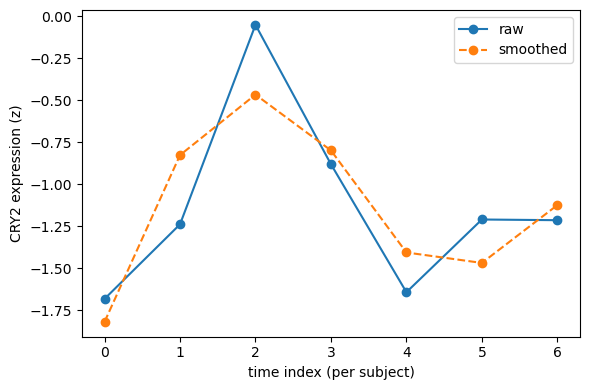

In [ ]:
# Raw vs smoothed for first subject and one gene

subj_idx = 0
gene_idx = 0  # index into available_genes

plt.figure(figsize=(6,4))
plt.plot(X_list[subj_idx][:, gene_idx], "o-", label="raw")
plt.plot(X_smooth_list[subj_idx][:, gene_idx], "o--", label="smoothed")
plt.xlabel("time index (per subject)")
plt.ylabel(f"{available_genes[gene_idx]} expression (z)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Define and fit SINDy model (with Fourier-of-time + polynomial state terms)

from pysindy.feature_library import GeneralizedLibrary

# Polynomial library over gene expression state variables
state_library = ps.PolynomialLibrary(
    degree=3,
    include_interaction=True,
    include_bias=True
)

# Fourier library over time (sin/cos of multiples of time)
time_library = ps.FourierLibrary(
    n_frequencies=2   # try 1 or 2 first; 3 may overfit 7 timepoints
)

# Combine state and time features
feature_library = GeneralizedLibrary([state_library, time_library])

# Sparse optimizer
optimizer = ps.STLSQ(alpha=0.1, threshold=0.1)

# Define SINDy model
model = ps.SINDy(
    feature_library=feature_library,
    # Uncomment part for pysindy versions below 1.7
    optimizer=optimizer#,
    #feature_names=list(available_genes)
)

# Fit using subject-wise smoothed trajectories
    # Uncommen part for pysindy versions below 1.7
model.fit(X_smooth_list, t=t_list)#, multiple_trajectories=True)

print("SINDy model fitted with Fourier + Polynomial library")
model.print()

SINDy model fitted with Fourier + Polynomial library
(x0)' = -11.263 x1 + -0.805 x2 + 1.247 x4 + 2.101 x6 + 0.156 x0^2 + 0.142 x0 x3 + -0.751 x0 x4 + -0.411 x0 x5 + 0.517 x1^2 + -0.859 x1 x3 + -0.561 x1 x4 + -0.340 x1 x5 + -0.054 x1 x6 + 0.960 x2 x4 + 0.858 x2 x5 + 0.342 x2 x6 + -0.284 x3 x4 + -0.732 x4^2 + 0.505 x4 x5 + -0.769 x4 x6 + 0.591 x5^2 + -0.348 x6^2 + 0.626 x0^2 x1 + -0.085 x0^2 x2 + -0.248 x0^2 x3 + -0.352 x0^2 x6 + -0.609 x0 x1 x2 + 0.193 x0 x1 x3 + -0.329 x0 x1 x4 + -0.292 x0 x1 x5 + 0.370 x0 x2^2 + -0.144 x0 x2 x4 + 1.084 x0 x2 x5 + -0.198 x0 x2 x6 + -0.064 x0 x3^2 + -0.016 x0 x3 x4 + 0.474 x0 x3 x6 + 0.518 x0 x4 x6 + 0.191 x0 x5 x6 + -1.612 x0 x6^2 + -0.038 x1^3 + -1.275 x1^2 x4 + -0.362 x1^2 x5 + 0.849 x1^2 x6 + 0.517 x1 x2 x3 + 0.920 x1 x2 x4 + 0.796 x1 x2 x5 + 0.208 x1 x2 x6 + 0.127 x1 x3 x4 + -0.628 x1 x3 x5 + 0.454 x1 x5 x6 + 0.697 x1 x6^2 + 0.038 x2^2 x6 + 0.390 x2 x3^2 + 0.290 x2 x3 x4 + 1.632 x2 x3 x6 + 0.909 x2 x4^2 + 0.020 x2 x4 x5 + 1.543 x2 x4 x6 + 1.022 x2 

In [16]:
# Save trained SINDy model
import pickle

with open("trained_sindy_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Saved SINDy model to trained_sindy_model.pkl")

Saved SINDy model to trained_sindy_model.pkl


Unique time indices: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
X_pooled shape: (7, 7)
X_pooled_smooth shape: (7, 7)


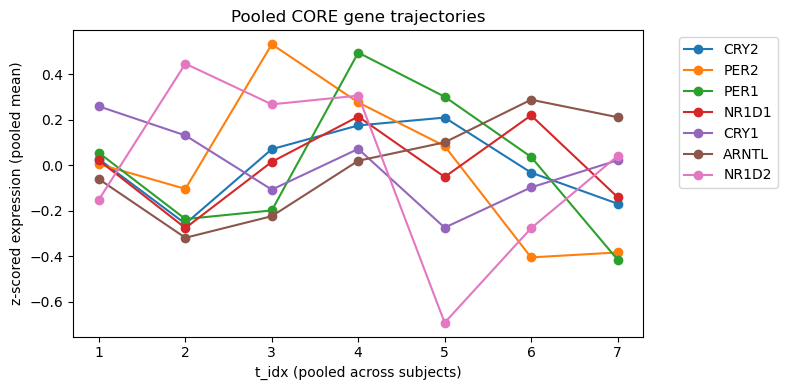

In [ ]:
# Build pooled trajectory (mean across subjects per time point)

# Unique time points (e.g. 1..7), sorted
t_vals = sorted(meta["t_idx"].unique())
print("Unique time indices:", t_vals)

X_pooled_rows = []

for t in t_vals:
    gsms_t = meta.loc[meta["t_idx"] == t, "gsm"]
    # expression for these samples: genes x n_samples_at_t
    X_t = expr_core[gsms_t]      # DataFrame
    mean_vec = X_t.mean(axis=1)  # Series (genes,)
    X_pooled_rows.append(mean_vec.values)

# Stack into a matrix: (T time points, n_genes)
X_pooled = np.vstack(X_pooled_rows)   # shape (T, n_genes)
print("X_pooled shape:", X_pooled.shape)

# Smooth pooled trajectories (expr_core already z-scored)
T_pooled, n_genes = X_pooled.shape
window_length = min(5, T_pooled if T_pooled % 2 == 1 else T_pooled - 1)
if window_length < 3:
    X_pooled_smooth = X_pooled.copy()
else:
    X_pooled_smooth = savgol_filter(
        X_pooled,
        window_length=window_length,
        polyorder=2,
        axis=0
    )

print("X_pooled_smooth shape:", X_pooled_smooth.shape)

# Sanity plot of pooled data
plt.figure(figsize=(8,4))
for i, g in enumerate(available_genes):
    plt.plot(t_vals, X_pooled[:, i], marker="o", label=g)

plt.xlabel("t_idx (pooled across subjects)")
plt.ylabel("z-scored expression (pooled mean)")
plt.title("Pooled CORE gene trajectories")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

X_true shape: (7, 7)
Time points: [1. 2. 3. 4. 5. 6. 7.]

ONE-STEP RMSE per gene:
  CRY2: 0.2563
  PER2: 0.5815
  PER1: 0.2865
  NR1D1: 0.2559
  CRY1: 0.3100
  ARNTL: 0.2003
  NR1D2: 0.3641

ONE-STEP R² per gene:
  CRY2: -3.0568
  PER2: -3.3197
  PER1: -0.2041
  NR1D1: -8.2669
  CRY1: -5.0775
  ARNTL: -0.1767
  NR1D2: -0.5662


c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\pysindy\pysindy.py:419: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  warnings.warn(
c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\pysindy\pysindy.py:419: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  warnings.warn(
c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\pysindy\pysindy.py:419: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  warnings.warn(
c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\pysindy\pysindy.py:419: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  warnings.warn(
c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\pysindy\pysindy.py:419: UserWarning: Control variables u were ignored because control

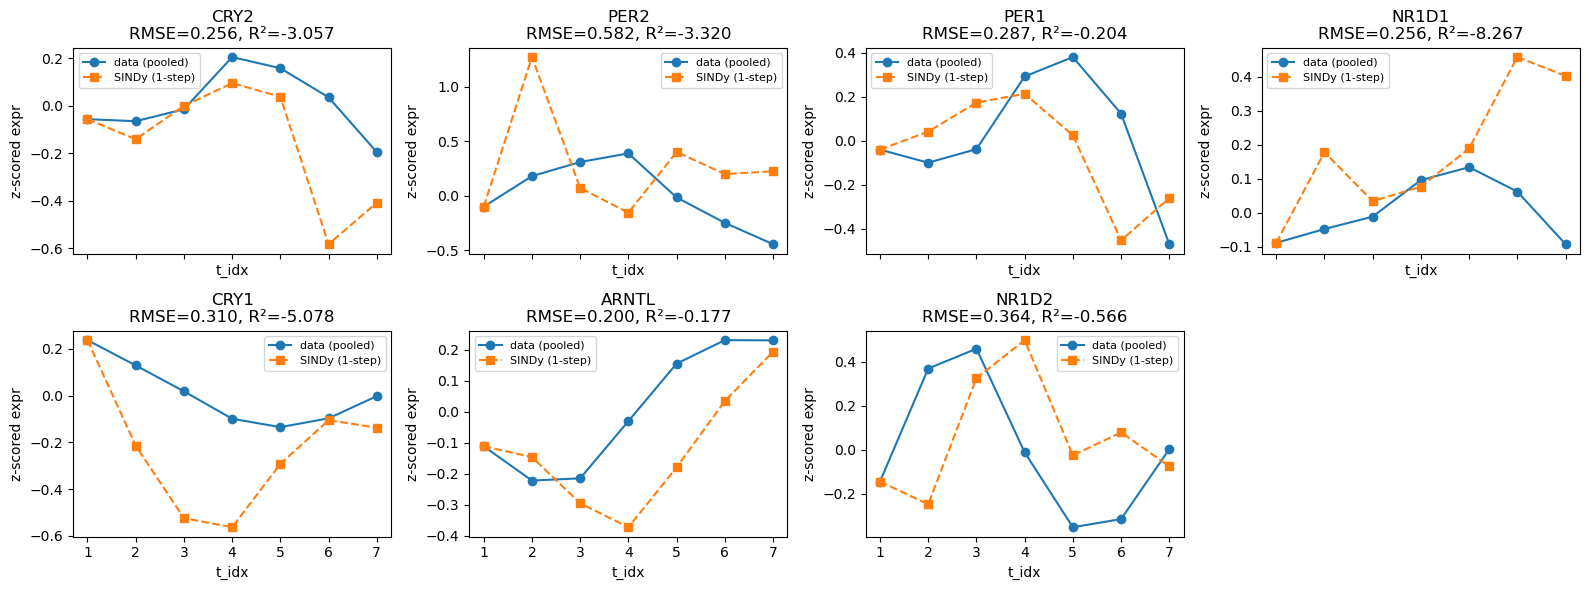

In [ ]:
# One-step SINDy predictions on pooled patient data (with Fourier time input)

X_true = X_pooled_smooth            # shape (T, n_genes)
t_arr  = np.asarray(t_vals, dtype=float)
T, n_genes = X_true.shape

# Build u_pooled: normalized time for FourierLibrary
u_pooled = ((t_arr - min_t) / period_T).reshape(-1, 1)  # shape (T, 1)

print("X_true shape:", X_true.shape)
print("Time points:", t_arr)

# One-step predictions: x_{k+1} ≈ x_k + dt * f(x_k, u_k)
X_pred_1step = np.zeros_like(X_true)
X_pred_1step[0, :] = X_true[0, :]    # anchor at first time point

for k in range(1, T):
    dt = t_arr[k] - t_arr[k-1]          # ~1.0
    x_prev = X_true[k-1, :]
    u_prev = u_pooled[k-1, :]          # (1,)
    dx_prev = model.predict(
        x_prev.reshape(1, -1),
        u=u_prev.reshape(1, -1)
    )[0]
    X_pred_1step[k, :] = x_prev + dt * dx_prev

# Metrics per gene
rmse_1step = np.sqrt(np.mean((X_true - X_pred_1step) ** 2, axis=0))
r2_1step   = np.zeros(n_genes)

for j in range(n_genes):
    if np.allclose(X_true[:, j], X_true[0, j]):
        r2_1step[j] = np.nan
    else:
        r2_1step[j] = r2_score(X_true[:, j], X_pred_1step[:, j])

print("\nONE-STEP RMSE per gene:")
for g, r in zip(available_genes, rmse_1step):
    print(f"  {g}: {r:.4f}")

print("\nONE-STEP R² per gene:")
for g, r in zip(available_genes, r2_1step):
    print(f"  {g}: {r:.4f}")

# Plots
ncols = 4
nrows = int(np.ceil(n_genes / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
axes = np.atleast_1d(axes).ravel()

for j, g in enumerate(available_genes):
    ax = axes[j]
    ax.plot(t_arr, X_true[:, j], "o-", label="data (pooled)")
    ax.plot(t_arr, X_pred_1step[:, j], "s--", label="SINDy (1-step)")
    ax.set_xlabel("t_idx")
    ax.set_ylabel("z-scored expr")
    ax.set_title(f"{g}\nRMSE={rmse_1step[j]:.3f}, R²={r2_1step[j]:.3f}")
    ax.legend(fontsize=8)

for k in range(j+1, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Free-run SINDy simulation on pooled data (with Fourier time input)

X_true = X_pooled_smooth
t_arr  = np.asarray(t_vals, dtype=float)
T, n_genes = X_true.shape

# Exogenous time input over the whole simulation
u_free = ((t_arr - min_t) / period_T).reshape(-1, 1)  # shape (T, 1)

# Initial condition: first pooled time point
x0 = X_true[0, :]

# SINDy simulate with exogenous input u(t)
# pysindy expects u(t) as array (T, n_inputs)
X_free = model.simulate(
    x0,
    t_arr * DT,   # time grid
    u=u_free
)

# Metrics per gene
rmse_free = np.sqrt(np.mean((X_true - X_free) ** 2, axis=0))
r2_free   = np.zeros(n_genes)

for j in range(n_genes):
    if np.allclose(X_true[:, j], X_true[0, j]):
        r2_free[j] = np.nan
    else:
        r2_free[j] = r2_score(X_true[:, j], X_free[:, j])

print("\nFREE-RUN RMSE per gene:")
for g, r in zip(available_genes, rmse_free):
    print(f"  {g}: {r:.4f}")

print("\nFREE-RUN R² per gene:")
for g, r in zip(available_genes, r2_free):
    print(f"  {g}: {r:.4f}")

# Plots
ncols = 4
nrows = int(np.ceil(n_genes / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
axes = np.atleast_1d(axes).ravel()

for j, g in enumerate(available_genes):
    ax = axes[j]
    ax.plot(t_arr, X_true[:, j], "o-", label="data (pooled)")
    ax.plot(t_arr, X_free[:, j], "s--", label="SINDy (free-run)")
    ax.set_xlabel("t_idx")
    ax.set_ylabel("z-scored expr")
    ax.set_title(f"{g}\nRMSE={rmse_free[j]:.3f}, R²={r2_free[j]:.3f}")
    ax.legend(fontsize=8)

for k in range(j+1, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

c:\Users\Sanchitha\anaconda3\envs\scanpy-env\lib\site-packages\pysindy\pysindy.py:730: UserWarning: Control variables u were ignored because control variables were not used when the model was fit
  warnings.warn(


KeyboardInterrupt: 

### SINDy model training (with Leloup priors) 
- Assumes that data extraction and processing of in-phase patients has already been done
- On single (in-phase) patient data with Leloup-Goldbeter priors, polynomial library
- Visualization on pooled (in-phase) patient data.
- One-step and Free-run work

In [ ]:
# Imports & paths

from pysindy.feature_library import PolynomialLibrary, CustomLibrary

# Try to import GeneralizedLibrary (to combine poly + custom features)
try:
    from pysindy.feature_library import GeneralizedLibrary
    HAVE_GENLIB = True
except ImportError:
    HAVE_GENLIB = False
    print("Warning: GeneralizedLibrary not found; using polynomial library only.")

# Paths
PROC_DIR = Path("../data/processed_new")

EXPR_PATH = PROC_DIR / "expr_gene_log2_qn_zscaled.pkl" # expression (genes x samples)
META_PATH = PROC_DIR / "meta.csv"                      # metadata

# Clock genes of interest (8 targets)
CORE_GENES = ["PER1","PER2","CRY1","CRY2","ARNTL","BMAL1","NR1D1","NR1D2"]

# Time step between successive t_idx samples
DT = 1.0

In [ ]:
# Load expression matrix and metadata

expr_gene_z: pd.DataFrame = pd.read_pickle(EXPR_PATH)
print("Expression matrix shape (genes x samples):", expr_gene_z.shape)

meta = pd.read_csv(META_PATH)
print("Metadata shape:", meta.shape)
meta.head()

Expression matrix shape (genes x samples): (29872, 148)
Metadata shape: (148, 6)


,Unnamed: 0,gsm,subject,condition,t_idx,file
0,0,GSM1168586,BB0012,R,1,..\data\raw\GSM1168586_BB0012_R_1.txt.gz
1,1,GSM1168587,BB0012,R,2,..\data\raw\GSM1168587_BB0012_R_2.txt.gz
2,2,GSM1168588,BB0012,R,3,..\data\raw\GSM1168588_BB0012_R_3.txt.gz
3,3,GSM1168589,BB0012,R,4,..\data\raw\GSM1168589_BB0012_R_4.txt.gz
4,4,GSM1168590,BB0012,R,5,..\data\raw\GSM1168590_BB0012_R_5.txt.gz


In [ ]:
# Subset to CORE circadian genes and align with metadata

available_genes = expr_gene_z.index.intersection(CORE_GENES)
print("Available CORE genes:", list(available_genes))

if len(available_genes) == 0:
    raise ValueError("None of the CORE genes found in expression matrix index.")

# genes x samples
expr_core = expr_gene_z.loc[available_genes]

# ensure gsm are strings and aligned
meta["gsm"] = meta["gsm"].astype(str)
expr_core.columns = expr_core.columns.astype(str)

common_gsms = sorted(set(expr_core.columns).intersection(set(meta["gsm"])))
expr_core = expr_core[common_gsms]
meta = meta[meta["gsm"].isin(common_gsms)].copy()

print("After aligning, expr_core shape (genes x samples):", expr_core.shape)
print("Number of unique subjects:", meta["subject"].nunique())

meta["t_idx"] = meta["t_idx"].astype(int)

Available CORE genes: ['CRY2', 'PER2', 'PER1', 'NR1D1', 'CRY1', 'ARNTL', 'NR1D2']
After aligning, expr_core shape (genes x samples): (7, 148)
Number of unique subjects: 22


In [ ]:
# Build list of subject trajectories (X_list) for training

subjects = sorted(meta["subject"].unique())
print("Subjects:", subjects)

X_list = []    # list of (T_i x n_genes)
t_list = []

for subj in subjects:
    m_sub = meta[meta["subject"] == subj].copy()
    m_sub = m_sub.sort_values("t_idx")
    
    gsm_order = m_sub["gsm"].tolist()
    missing = [g for g in gsm_order if g not in expr_core.columns]
    if missing:
        print(f"Warning: subject {subj} missing GSMs in expression matrix:", missing)
        continue

    # samples x genes
    X_subj = expr_core[gsm_order].T.values  # (T_subj, n_genes)

    if X_subj.shape[0] < 3:
        print(f"Skipping subject {subj}: only {X_subj.shape[0]} timepoints")
        continue

    X_list.append(X_subj)
    t_list.append(np.arange(X_subj.shape[0]) * DT)

print(f"Built {len(X_list)} trajectories for SINDy.")
print("Example trajectory shape:", X_list[0].shape if X_list else None)

Subjects: ['BB0012', 'BB0028', 'BB0040', 'BB0041', 'BB0061', 'BB0072', 'BB0080', 'BB0098', 'BB0100', 'BB0102', 'BB0104', 'BB0121', 'BB0135', 'BB0141', 'BB0148', 'BB0219', 'BB0236', 'BB0239', 'BB0246', 'BB0264', 'BB0272', 'BB0289']
Built 22 trajectories for SINDy.
Example trajectory shape: (7, 7)


Smoothing done.


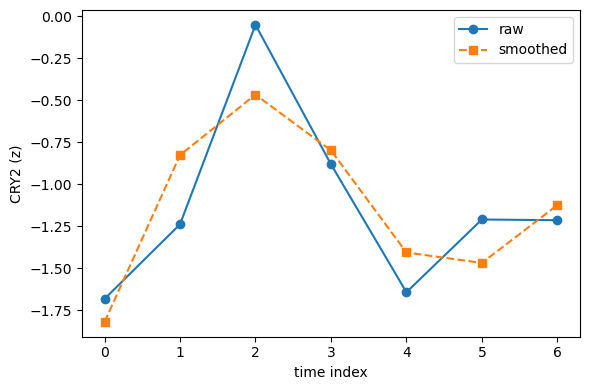

In [ ]:
# Smooth trajectories (for noisy microarray data)

X_smooth_list = []

for X_subj in X_list:
    T_subj, n_genes = X_subj.shape
    window_length = min(5, T_subj if T_subj % 2 == 1 else T_subj - 1)
    if window_length < 3:
        X_smooth_list.append(X_subj)
        continue

    X_smooth = savgol_filter(
        X_subj,
        window_length=window_length,
        polyorder=2,
        axis=0
    )
    X_smooth_list.append(X_smooth)

print("Smoothing done.")

# quick check: raw vs smoothed, one subject & one gene
subj_idx = 0
gene_idx = 0

plt.figure(figsize=(6,4))
plt.plot(X_list[subj_idx][:, gene_idx], "o-", label="raw")
plt.plot(X_smooth_list[subj_idx][:, gene_idx], "s--", label="smoothed")
plt.xlabel("time index")
plt.ylabel(f"{available_genes[gene_idx]} (z)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Define Leloup-inspired feature library
from pysindy.feature_library import CustomLibrary, PolynomialLibrary, GeneralizedLibrary

# Map gene names to indices
gene_to_idx = {g: i for i, g in enumerate(available_genes)}

def first_present(names):
    """Return the first available gene and its index."""
    for g in names:
        if g in gene_to_idx:
            return g, gene_to_idx[g]
    return None, None

per_name, per_idx   = first_present(["PER1","PER2"])
cry_name, cry_idx   = first_present(["CRY1","CRY2"])
bmal_name, bmal_idx = first_present(["ARNTL","BMAL1"])
rev_name, rev_idx   = first_present(["NR1D1","NR1D2"])

print("Leloup mapping:")
print("  PER  ->", per_name)
print("  CRY  ->", cry_name)
print("  BMAL ->", bmal_name)
print("  REV  ->", rev_name)

# Helper to ensure x is always 2D
def ensure_2d(x):
    x = np.asarray(x)
    if x.ndim == 1:
        return x.reshape(1, -1)
    return x

# Custom Leloup-style feature functions
custom_functions = []
custom_names = []

def ensure_2d(x):
    """Make x shape (n_samples, n_features)."""
    x = np.asarray(x)
    if x.ndim == 1:
        return x.reshape(1, -1)
    return x


def hill_activation(idx, K=1.0, n=2.0, label="hill_B"):
    def f(x):
        X = ensure_2d(x)
        B = np.maximum(X[:, idx], 0.0)
        return (B**n) / (K**n + B**n + 1e-12)
    f.__name__ = label
    return f, label


def PC_complex(x):
    X = ensure_2d(x)
    return X[:, per_idx] * X[:, cry_idx]
PC_complex.__name__ = f"{per_name}*{cry_name}"

print("Custom Leloup-inspired features:", custom_names)

custom_library = CustomLibrary(
    library_functions=custom_functions,
    function_names=custom_names
)

# Base polynomial library
poly_library = PolynomialLibrary(
    degree=2,
    include_interaction=True,
    include_bias=True
)

# Combine polynomial + custom libraries
feature_library = GeneralizedLibrary([poly_library, custom_library])

print("Using GeneralizedLibrary(poly + Leloup custom features).")

Leloup mapping:
  PER  -> PER1
  CRY  -> CRY1
  BMAL -> ARNTL
  REV  -> NR1D1
Custom Leloup-inspired features: []
Using GeneralizedLibrary(poly + Leloup custom features).


In [ ]:
# Fit SINDy model 
optimizer = ps.STLSQ(alpha=0.05, threshold=0.1)

model = ps.SINDy(
    feature_library=feature_library,   # from Cell 6
    # Uncomment for pysindy versions < 1.7
    optimizer=optimizer#,
    #feature_names=list(available_genes)
)
    
# Uncomment for pysindy versions < 1.7
model.fit(X_smooth_list, t=DT)#, multiple_trajectories=True)

print("SINDy model fitted.")
model.print()

SINDy model fitted.
(x0)' = -0.163 1 + 0.314 x6 + 0.224 x0 x1 + -0.246 x0 x3 + -0.321 x0 x4 + -0.177 x0 x5 + -0.127 x0 x6 + -0.183 x1 x4 + 0.351 x1 x6 + 0.126 x2 x5 + 0.257 x3 x4 + -0.180 x3 x5 + -0.539 x3 x6 + 0.201 x4^2 + 0.168 x4 x5 + -0.215 x4 x6 + -0.488 x5 x6 + -0.166 x6^2
(x1)' = -0.148 1 + 0.153 x0 + 0.201 x3 + 0.565 x6 + 0.308 x0 x1 + -0.482 x0 x3 + -0.556 x0 x4 + 0.260 x1^2 + -0.274 x1 x2 + 0.178 x1 x6 + 0.244 x2 x3 + 0.491 x2 x4 + -0.301 x2 x6 + -0.225 x3 x6 + 0.257 x4^2 + 0.158 x4 x5 + -0.580 x4 x6 + -0.269 x5 x6 + -0.221 x6^2
(x2)' = -0.228 1 + 0.319 x2 + -0.336 x3 + -0.168 x5 + 0.252 x6 + 0.183 x0 x1 + -0.264 x0 x4 + -0.244 x0 x5 + -0.164 x1^2 + -0.109 x1 x3 + -0.167 x1 x4 + 0.152 x1 x6 + -0.151 x2^2 + -0.572 x2 x4 + 0.380 x2 x6 + 0.498 x3 x4 + -0.478 x3 x6 + 0.218 x4 x5 + 0.204 x5^2 + -0.219 x5 x6
(x3)' = -0.194 x0 x2 + -0.209 x0 x4 + -0.171 x0 x6 + 0.148 x1 x6 + 0.152 x2 x3 + 0.103 x3 x6
(x4)' = -0.249 x1 + -0.203 x2 + -0.342 x6 + 0.249 x0 x3 + 0.199 x0 x4 + 0.153 x0 x5

Unique time indices: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
X_pooled shape: (7, 7)
X_pooled_smooth shape: (7, 7)


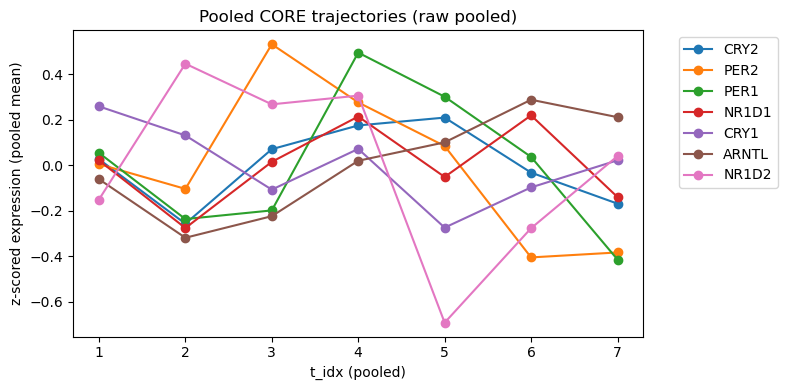

In [ ]:
# Pooled trajectory across subjects for testing model

t_vals = sorted(meta["t_idx"].unique())
print("Unique time indices:", t_vals)

X_pooled_rows = []

for t in t_vals:
    gsms_t = meta.loc[meta["t_idx"] == t, "gsm"]
    X_t = expr_core[gsms_t]          # genes x n_samples_at_t
    mean_vec = X_t.mean(axis=1).values  # (n_genes,)
    X_pooled_rows.append(mean_vec)

X_pooled = np.vstack(X_pooled_rows)      # (T, n_genes)
print("X_pooled shape:", X_pooled.shape)

# standardize pooled per gene (for nicer scales)
X_pooled_std = (X_pooled - X_pooled.mean(axis=0)) / (X_pooled.std(axis=0) + 1e-8)

# smooth pooled standardized trajectory
T = X_pooled_std.shape[0]
window_length = min(5, T if T % 2 == 1 else T - 1)
if window_length < 3:
    X_pooled_smooth = X_pooled_std.copy()
else:
    X_pooled_smooth = savgol_filter(
        X_pooled_std,
        window_length=window_length,
        polyorder=2,
        axis=0
    )

print("X_pooled_smooth shape:", X_pooled_smooth.shape)

# sanity plot
plt.figure(figsize=(8,4))
for i, g in enumerate(available_genes):
    plt.plot(t_vals, X_pooled[:, i], marker="o", label=g)
plt.xlabel("t_idx (pooled)")
plt.ylabel("z-scored expression (pooled mean)")
plt.title("Pooled CORE trajectories (raw pooled)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

X_true shape: (7, 7)
Time points: [1. 2. 3. 4. 5. 6. 7.]

ONE-STEP RMSE per gene:
  CRY2: 0.6774
  PER2: 0.8769
  PER1: 0.6767
  NR1D1: 0.5002
  CRY1: 0.3939
  ARNTL: 0.5014
  NR1D2: 0.4310

ONE-STEP R² per gene:
  CRY2: 0.2903
  PER2: 0.0363
  PER1: 0.4188
  NR1D1: 0.0266
  CRY1: 0.7398
  ARNTL: 0.6914
  NR1D2: 0.7047


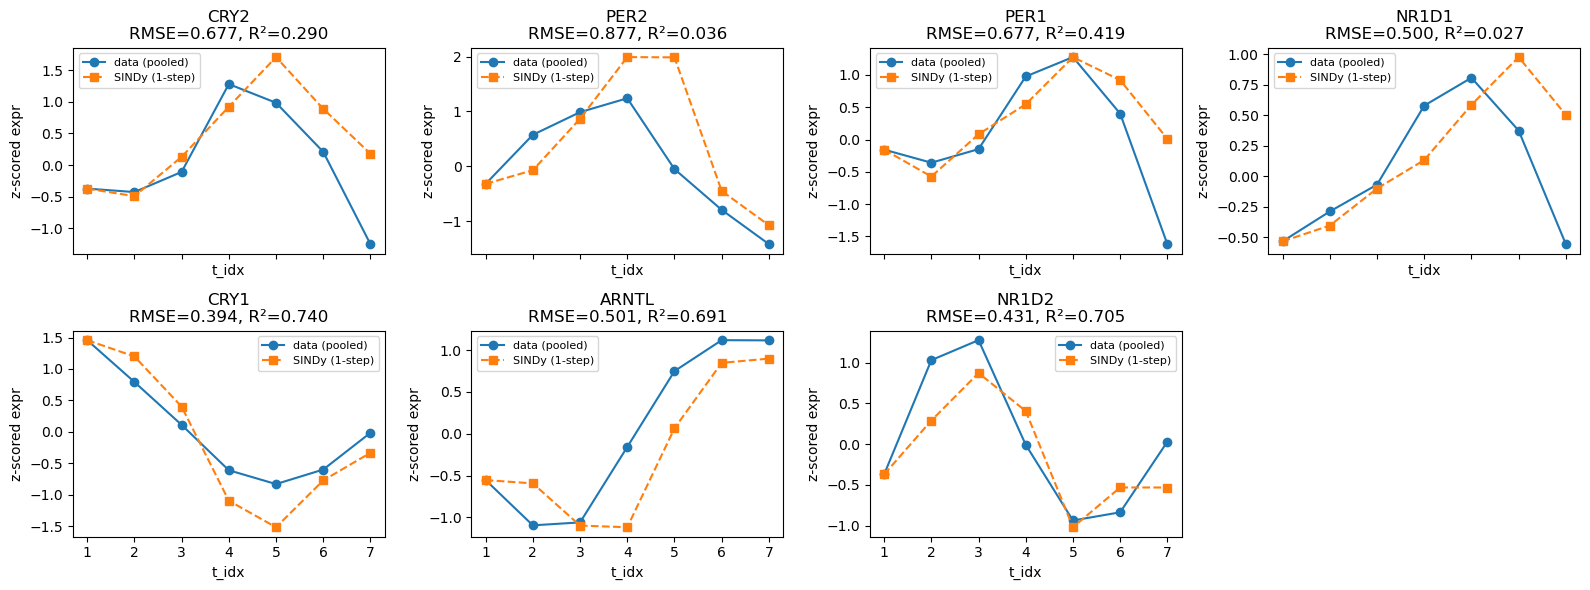

In [ ]:
# One-step SINDy predictions on pooled in-phase data

X_true = X_pooled_smooth
t_arr  = np.asarray(t_vals, dtype=float)
T, n_genes = X_true.shape

print("X_true shape:", X_true.shape)
print("Time points:", t_arr)

X_pred_1step = np.zeros_like(X_true)
X_pred_1step[0] = X_true[0]

for k in range(1, T):
    dt = t_arr[k] - t_arr[k-1]
    x_prev = X_true[k-1]
    dx_prev = model.predict(x_prev.reshape(1, -1))[0]
    X_pred_1step[k] = x_prev + dt * dx_prev

rmse_1step = np.sqrt(np.mean((X_true - X_pred_1step) ** 2, axis=0))
r2_1step   = np.zeros(n_genes)

for j in range(n_genes):
    if np.allclose(X_true[:, j], X_true[0, j]):
        r2_1step[j] = np.nan
    else:
        r2_1step[j] = r2_score(X_true[:, j], X_pred_1step[:, j])

print("\nONE-STEP RMSE per gene:")
for g, r in zip(available_genes, rmse_1step):
    print(f"  {g}: {r:.4f}")

print("\nONE-STEP R² per gene:")
for g, r in zip(available_genes, r2_1step):
    print(f"  {g}: {r:.4f}")

# plots
ncols = 4
nrows = int(np.ceil(n_genes / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
axes = np.atleast_1d(axes).ravel()

for j, g in enumerate(available_genes):
    ax = axes[j]
    ax.plot(t_arr, X_true[:, j], "o-", label="data (pooled)")
    ax.plot(t_arr, X_pred_1step[:, j], "s--", label="SINDy (1-step)")
    ax.set_xlabel("t_idx")
    ax.set_ylabel("z-scored expr")
    ax.set_title(f"{g}\nRMSE={rmse_1step[j]:.3f}, R²={r2_1step[j]:.3f}")
    ax.legend(fontsize=8)

for k in range(j+1, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()


FREE-RUN RMSE per gene:
  CRY2: 0.8551
  PER2: 0.7786
  PER1: 0.9860
  NR1D1: 0.5548
  CRY1: 1.4549
  ARNTL: 1.0859
  NR1D2: 0.9128

FREE-RUN R² per gene:
  CRY2: -0.1311
  PER2: 0.2402
  PER1: -0.2337
  NR1D1: -0.1977
  CRY1: -2.5496
  ARNTL: -0.4475
  NR1D2: -0.3247


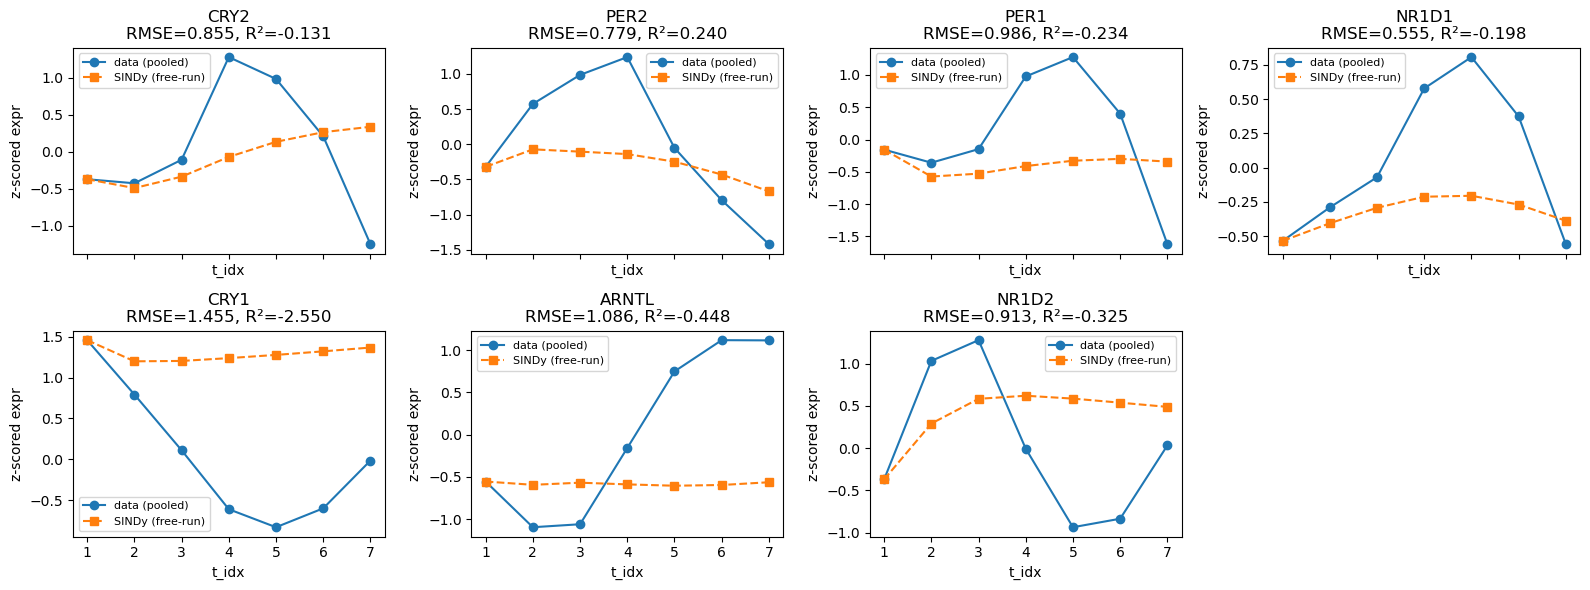

In [ ]:
# Free-run SINDy simulation on pooled in-phase data

X_true = X_pooled_smooth
t_arr  = np.asarray(t_vals, dtype=float)
T, n_genes = X_true.shape

X_free = np.zeros_like(X_true)
X_free[0] = X_true[0]   # start at pooled initial state

for k in range(1, T):
    dt = t_arr[k] - t_arr[k-1]
    x_prev = X_free[k-1]
    dx_prev = model.predict(x_prev.reshape(1, -1))[0]
    X_free[k] = x_prev + dt * dx_prev

rmse_free = np.sqrt(np.mean((X_true - X_free) ** 2, axis=0))
r2_free   = np.zeros(n_genes)

for j in range(n_genes):
    if np.allclose(X_true[:, j], X_true[0, j]):
        r2_free[j] = np.nan
    else:
        r2_free[j] = r2_score(X_true[:, j], X_free[:, j])

print("\nFREE-RUN RMSE per gene:")
for g, r in zip(available_genes, rmse_free):
    print(f"  {g}: {r:.4f}")

print("\nFREE-RUN R² per gene:")
for g, r in zip(available_genes, r2_free):
    print(f"  {g}: {r:.4f}")

# plots
ncols = 4
nrows = int(np.ceil(n_genes / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
axes = np.atleast_1d(axes).ravel()

for j, g in enumerate(available_genes):
    ax = axes[j]
    ax.plot(t_arr, X_true[:, j], "o-", label="data (pooled)")
    ax.plot(t_arr, X_free[:, j], "s--", label="SINDy (free-run)")
    ax.set_xlabel("t_idx")
    ax.set_ylabel("z-scored expr")
    ax.set_title(f"{g}\nRMSE={rmse_free[j]:.3f}, R²={r2_free[j]:.3f}")
    ax.legend(fontsize=8)

for k in range(j+1, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()